# Predicting Pass Success

This notebook creates an xPass model, where xPass is the probability of a pass being successful given certain features of the circumstances under which a pass is made.

Initially, a simple model is created which simply uses the position on the pitch from which the pass was made, but this is then expanded on to include additional features.

Finally the xPass model is used to produce a scouting report on two players from one league.

### Notes from David Sumpter on the problem

Use p values for seeing whether there is a strong relationship
x and y considered as separate parameters
could do distance from the middle of the pitch, or distance from opponent's goal as an additional parameter
	would be interesting as a single variable model

end-coordinates of a pass - what do you do for unsuccessful passes?

what is a successful pass?
	naively this could just be whether it's successful (ie ,ends up with own player) or unsuccessful (ie, ends up off pitch or with opposition)
	but could be whether you're own player ends up with the ball
	could improve the model by considering this in part ii

What is a good passer?
	Someone who overperforms your passing model - in the same way as xG

Using the same data for test and train - it's not a machine learning course...

When doing the comparison, just compare within the league we care about. Pick out one or two players that are deem to be good players based 
	on the results of our model - a focussed analysis of one or two players you'd be interested in signing (may want to take in context of
	other data on the player, eg basic demographic things like age - eg, you wouldn't want to sign a 33 year old necessarily)

Weakness:
* Fitted over a certain number of leagues
* It would be good to include pressure on player (from tutorial team)
	
Can use ridge-regression in scikit-learn (punishes if too many parameters)

In [93]:
import json
import os
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import FCPython

# Loading the data

This assumes that Wyscout data is held in a folder called 'data/' within the repository holding this notebook

In [239]:
def load_wyscout_event_data(data_folder='data/'):
    """
    Given a folder location holding Wyscout data, load all json files for event data and
    put all data in a single dataframe, which is returned.
    """
    
    data_folder = data_folder.strip('/')
    
    event_files = []
    events = []
    
    for root, dirs, files in os.walk(f'{data_folder}/events'):
        for file in files:
            event_files.append(f'{root}/{file}')

    for file_location in event_files:
        with open(file_location, encoding="utf8") as json_data:
            event_df_for_file = pd.DataFrame(json.load(json_data))
            events.append(event_df_for_file)
    
    events_df = pd.concat(events) 
    events_df = events_df.reset_index(drop=True)
    
    return events_df

In [240]:
event_data = load_wyscout_event_data()

# Data exploration

Before doing anything we need to understand what the data we have looks like, let's do a little exploring.

### Questions to answer

* What do passes look like in the data?
* Are there different types of passes?
* How do we know if a pass was successful? 
* Are there different possible definitions of 'success'?
* What are the axes origins for x and y co-ordinates?
* Would it make more sense to shift the origin?
* Other than x and y co-ordinates, what other features could we possibly use in model extensions?
* How can we know the end location of the pass if it is unsuccessful?

In [224]:
class PassDataPipeline:
    def __init__(self):
        self.filters = list()
    
    def add_filters(self, filters_to_add):
        self.filters.extend(filters_to_add)
    
    def run_get_pass_data_pipeline(self, event_data):
        pass_data = event_data[event_data['eventName'] == 'Pass'].copy()
        for f in self.filters:
            pass_data = f(pass_data)
        
        return pass_data

In [250]:
def remove_rows_with_no_pass_end_position(pass_data):
    """
    All passes should have an end location. If any rows don't, remove them from the data
    """
    pass_data = pass_data.copy()
    number_of_coords = pass_data['positions'].apply(lambda x: len(x))
    pass_data = pass_data[number_of_coords == 2]
    pass_data = pass_data.reset_index(drop=True)
    
    return pass_data
    

def get_success_flag_from_tags(pass_data):
    """
    Extract a success flag from tags field of pass data:
        1801 means success
        1802 mean not a success
    """
    all_tags = pass_data['tags'].copy().apply(lambda x: [tag['id'] for tag in x])
    pass_data['success'] = all_tags.apply(lambda x: True if 1801 in x and 1802 not in x else False)
    
    return pass_data


def get_start_coordinates_of_pass_from_position(pass_data):
    """
    Extract the start co-ordinates of a pass from the position field of the event data
    """
    pass_data = pass_data.copy()
    pass_data['pass_start_x'] = pass_data['positions'].apply(lambda coords: coords[0]['x'])
    pass_data['pass_start_y'] = pass_data['positions'].apply(lambda coords: coords[0]['y'])

    return pass_data


def get_end_coordinates_of_pass_from_position(pass_data):
    """
    Exctract the end co-ordinates of a pass from the position field of the event data
    If there is no end co-ordinates, then assume pass end is same as pass start

    Note, this doesn't make any attempt to work out the intended end 
    co-ordinates of a failed pass
    """
    pass_data = pass_data.copy()

    # For some reason there are two passes for which there are only one co-ordinate
    number_of_coords = pass_data['positions'].apply(lambda x: len(x))
    inferred_end_coordiates = pass_data[number_of_coords == 1]['positions'].apply(
        lambda coords: [{'y': coords[0]['y'], 'x': coords[0]['x']},
                        {'y': coords[0]['y'], 'x': coords[0]['x']}])
    pass_data['positions'].update(inferred_end_coordiates)

    pass_data['pass_end_x'] = pass_data['positions'].apply(
            lambda coords: coords[1]['x'])
    pass_data['pass_end_y'] = pass_data['positions'].apply(
            lambda coords: coords[1]['y'])

    return pass_data


def get_start_coordinates_squared(pass_data):
    """
    Derive new features of start coordinates squared from start coordinates.
    Note that this filter must be applied after get_start_coordinates_of_pass_from_position()
    """
    pass_data = pass_data.copy()
    
    pass_data['pass_start_x_squared'] = pass_data['pass_start_x'] ** 2
    pass_data['pass_start_y_squared'] = pass_data['pass_start_y'] ** 2
    
    return pass_data


def get_start_coordinates_in_metres(pass_data):
    """
    Derive the start co-ordinates in metres from the start co-ordinates.
    Note that this filter must be applied after get_start_coordinates_of_pass_from_position()
    """
    pass_data = pass_data.copy()
    pass_data['pass_start_x_metres'] = pass_data['pass_start_x'] * 105 / 100
    pass_data['pass_start_y_metres'] = pass_data['pass_start_y'] * 65 / 100
    
    return pass_data

In [251]:
# This code would load the pass data in one go. As this has all been a bit exploratory, we've built this up bit by bit instead

# pass_data_pipeline = PassDataPipeline()
# pass_data_pipeline.add_filters([remove_rows_with_no_pass_end_position, get_success_flag_from_tags, 
#                                 get_start_coordinates_of_pass_from_position, get_end_coordinates_of_pass_from_position,
#                                 get_start_coordinates_squared])
# pass_data = pass_data_pipeline.run_get_pass_data_pipeline(event_data)

In [34]:
event_data.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


In [46]:
event_data.shape

(3251294, 12)

In [36]:
event_data['eventName'].unique()

array(['Pass', 'Duel', 'Foul', 'Free Kick', 'Shot', 'Save attempt',
       'Others on the ball', 'Interruption', 'Goalkeeper leaving line',
       'Offside'], dtype=object)

In [86]:
pass_data = event_data[event_data['eventName'] == 'Pass'].copy()

In [40]:
pass_data['subEventName'].unique()

array(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Launch',
       'Cross', 'Hand pass'], dtype=object)

In [69]:
# What tags to we have, and what do those tags mean?
all_tags = pass_data['tags'].apply(lambda x: [tag['id'] for tag in x])
unique_tags = list(set([item for sublist in all_tags.values for item in sublist]))

In [73]:
unique_tags.sort()
unique_tags

[102,
 201,
 301,
 302,
 401,
 402,
 403,
 502,
 504,
 801,
 901,
 1001,
 1401,
 1801,
 1802,
 1901,
 2001,
 2101]

#### What types of pass do we have in the data

Passes are flagged in the `eventName` field with value `Pass`.
There are seven types of pass: `'Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Launch', 'Cross', 'Hand pass'`
Definitions for these types of passes can be found here https://footballdata.wyscout.com/events-manual/

Do we want to include all of these in our model? Is it fair for example to include `Hand pass` which is presumably made exclusively by goalkeepers?

Alternatively, could we include these as features in our model? This could allow us to identify players who have certain passing skills.

#### What do the tags we get for passing mean?

* 102: Own goal
* 201: Opportunity
* 301: Assist
* 302: Key pass
* 401: Left foot
* 402: Right foot
* 403: Head
* 502: Free space left
* 504: Take on right
* 801: High
* 901: Through
* 1001: Fairplay - this is when a player kicks the ball out so some other player needs medical treatment. Should remove these.
* 1401: Interception
* 1801: Accurate
* 1802: Not accurate
* 1901: Counter attack
* 2001: Dangerous ball lost
* 2101: Blocked

In [87]:
pass_data['all_tags'] = pass_data['tags'].apply(lambda x: [tag['id'] for tag in x])
pass_data['success'] = pass_data['all_tags'].apply(lambda x: True if 1801 in x and 1802 not in x else False)

In [92]:
len(pass_data[pass_data['success']]) / len(pass_data)

0.8294688467422552

#### How can we identify a successful pass?

We can see that a pass is successful in the most basic way by looking at the tags: `1801` means successful and `1802` means not successful.

This identifies 83% of passes as being successful across all competitions, which seems about right but maybe a little high.

An alterntive definition of 'successful' could include passes where after any interceptions or duels the passing team retain the ball. This is something to consider in future iterations of the model.

In [103]:
# For some reason there are two passes for which there are only one co-ordinate
number_of_coords = pass_data['positions'].apply(lambda x: len(x))
pass_data[number_of_coords == 1]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,all_tags,success,pass_start_x,pass_start_y
98656,8,Pass,1.857048,263647730,2058016,1H,7905,"[{'y': 50, 'x': 50}]",85,Simple pass,[],5629,[],False,[50],[50]
100297,8,Pass,1.892339,263883958,2058017,1H,14943,"[{'y': 51, 'x': 50}]",85,Simple pass,[],9598,[],False,[50],[51]


In [104]:
# Lets remove these two data points from the passing data
pass_data = pass_data[number_of_coords == 2]

In [111]:
pass_data['pass_start_x'] = pass_data['positions'].apply(lambda coords: coords[0]['x'])
pass_data['pass_start_y'] = pass_data['positions'].apply(lambda coords: coords[0]['y'])
pass_data['pass_end_x'] = pass_data['positions'].apply(lambda coords: coords[1]['x'])
pass_data['pass_end_y'] = pass_data['positions'].apply(lambda coords: coords[1]['y'])

In [112]:
print(pass_data['pass_start_x'].min(), pass_data['pass_start_x'].max())
print(pass_data['pass_start_y'].min(), pass_data['pass_start_y'].max())

print(pass_data['pass_end_x'].min(), pass_data['pass_end_x'].max())
print(pass_data['pass_end_y'].min(), pass_data['pass_end_y'].max())

0 100
0 101
0 100
0 101


#### What does the co-ordinate system mean?

In the Wyscout documentation (https://apidocs.wyscout.com/matches-wyid-events#6a-available-schemes-and-relative-positions) the postions are described as being the *position in percentage from the left corner of the attacking team*

This means that we should be able to just use the positions without manipulation or caring about which half we're in. To create other features (eg, anlges/ distances) we will need to convert the co-ordinate system to metres

Looking at the data for a switch in posession confirms the definition from the documentation

In [121]:
pass_data.iloc[15:18]

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId,all_tags,success,pass_start_x,pass_start_y,pass_end_x,pass_end_y
19,8,Pass,32.805618,177959202,2499719,1H,14853,"[{'y': 5, 'x': 23}, {'y': 19, 'x': 63}]",83,High pass,[{'id': 1802}],1631,[1802],False,23,5,63,19
20,8,Pass,35.685082,177959184,2499719,1H,370224,"[{'y': 81, 'x': 37}, {'y': 95, 'x': 45}]",82,Head pass,[{'id': 1802}],1609,[1802],False,37,81,45,95
21,8,Pass,36.661264,177959204,2499719,1H,14763,"[{'y': 5, 'x': 55}, {'y': 22, 'x': 67}]",82,Head pass,[{'id': 1801}],1631,[1801],True,55,5,67,22


In [122]:
x_start_metres = pass_data['pass_start_x'] * 105 / 100
y_start_metres = pass_data['pass_start_y'] * 65 / 100

# How does position on the pitch contribute?

Let's start by simply plotting a heatmap of pass start co-ordinates for all passes, completed passes and uncompleted passes to see how these differ. We expect to see more passes fail higher up the pitch and from positions where balls are typically played into the box (ie, crosses, through balls, etc).

In [252]:
def plot_event_heatmap(y_events, x_events, title, no_of_bins=10):
    """
    Given series of event positions (one series for y and one for x coordinates) plot a heatmap 
    for those events, with the pitch split into no_of_bins by no_of_bins areas
    """
    histogram_values = np.histogram2d(y_events, x_events, bins=no_of_bins)
    fig, ax = FCPython.createPitch(105, 65, 'meters', 'black')
    pos=ax.imshow(histogram_values[0], extent=(0, 105, 0, 65), aspect='auto', cmap=plt.cm.Reds)
    fig.colorbar(pos, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

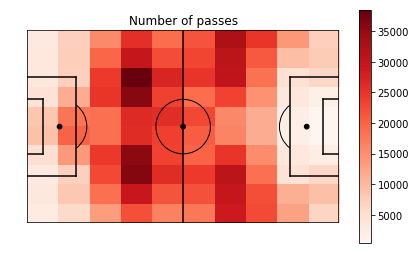

In [254]:
plot_event_heatmap(y_start_metres, x_start_metres, 'Number of passes')

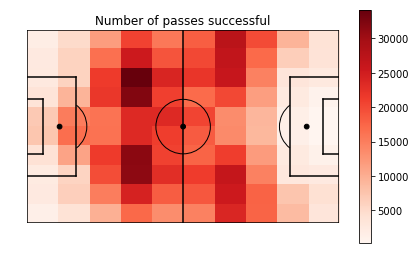

In [255]:
plot_event_heatmap(y_start_metres[pass_data['success']], 
                   x_start_metres[pass_data['success']], 
                   'Number of passes successful')

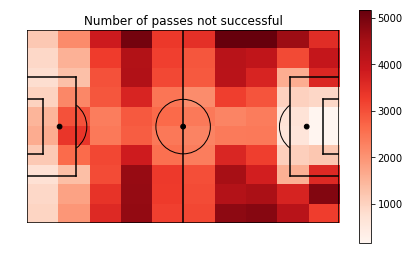

In [256]:
plot_event_heatmap(y_start_metres[~pass_data['success']], 
                   x_start_metres[~pass_data['success']], 
                   'Number of passes not successful')

# Investigating correlation between coordinates and success

Lets plot scatters to see what the relationships look like, then create our first model of pass success.

In [195]:
def plot_relationship_scatter(pass_data, variable_to_plot, curve_parameters=None):
    """
    Plot the relationship between the variable to plot and the probability of a pass success, based on the data
    provided in the pass_data DataFrame.
    If curve_parameters is also present, then plot the logistic regression curve with these values too
    
    Parameters
    ----------
    pass_data (pd.DataFrame)
        DataFrame containing event data relating to passes, detailing whether each pass is successful, and 
        containing the variable to plot
    
    variable_to_plot (str)
        The name of a field in the pass_data for which to plot a relationship between it and pass success probability
    
    curve_parameters (list)
        Parameters for a logistic regression to plot.
    """
    passcount_dist = np.histogram(pass_data[variable_to_plot], bins=40, range=[0, 100])
    successcount_dist = np.histogram(pass_data[pass_data['success']][variable_to_plot], bins=40, range=[0, 100])
    prob_success = np.divide(successcount_dist[0], passcount_dist[0])
    variable_vals = passcount_dist[1]
    mid_variable_vals = (variable_vals[:-1] + variable_vals[1:]) / 2
    
    fig, ax = plt.subplots(num=2)
    ax.plot(mid_variable_vals, prob_success, linestyle='none', marker= '.', markerSize= 12, color='black')
    
    if curve_parameters is not None:
        exponential_value = np.array([0.0] * len(mid_variable_vals))
        for i, param  in enumerate(curve_parameters):
            exponential_value += param * pow(mid_variable_vals, i)
        xPass_prob = 1 / (1 + np.exp(exponential_value))
        ax.plot(mid_variable_vals, xPass_prob, linestyle='solid', color='black')
    
    ax.set_ylabel('Probability pass success')
    ax.set_xlabel(variable_to_plot)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

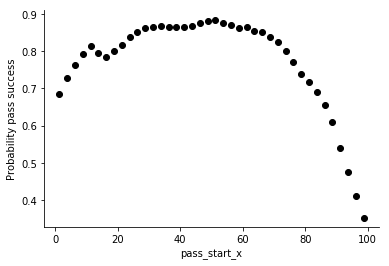

In [188]:
plot_relationship_scatter(pass_data, 'pass_start_x')

In the x-direction (ie, along the length of the pitch) this confirms what we can see in the plot of the pitch above:
* Near a team's own goal line passes have a middling probability of success. Here passes may be defensive clearances
* In the middle of the park, passes are most likely to be successful. Here teams are more likely to have the ball under less pressure from opponents
* In the final third probability of pass success increases. Passes need to be more creative here to break through an opponent defensive line, and many will be crosses which tend to be less successful.

This looks like a quadratic relationship, so likely that including x<sup>2</sup> will improve the model

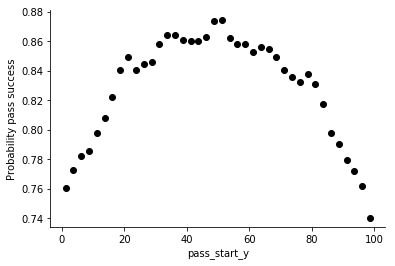

In [167]:
plot_relationship_scatter(pass_data, 'pass_start_y')

In the y-direction (ie, along the width of the pitch):
* Passes are less likely to be successful nearer the touch lines. This is not surprising as here we're more likely to see crosses, or other balls into the box
* Passes are more likely to be successful in the centre of the width. Based on the heatmaps above these are likely to be dominated by passes in the centre of the park, where there is often an emphasis on keeping posession.

This looks like a quadratic relationship, so likely that including y<sup>2</sup> will improve the model

# Fitting a logistic regression to variables derived from single variables

Based on what we see in the plots above we should look into logistic regression for x, x<sup>2</sup>, y and y<sup>2</sup>

In [209]:
def calculate_and_plot_logistic_polynomial_regression_curve(pass_data, variables=list(), plot=True):
    """
    Calculate and print logistic regression model for variables provided, and optionally plot curve with real data
    
    Parameters
    ----------
    pass_data (pd.DataFrame)
        DataFrame containing event data relating to passes, detailing whether each pass is successful, and 
        containing the variables for the logistic regression
    
    variables (list)
        Fields in the DataFrame to use in logistic regression model
    
    plot (bool)
        Whether to product a plot. If making a plot it must either be for a single variable model or for a model
        where all variables are powers of a single variable
        
    """
    test_model = smf.glm(formula=f"success ~ {' + '.join(variables)}", data=pass_data, 
                         family=sm.families.Binomial()).fit()
    print(test_model.summary())
    if plot:
        plot_relationship_scatter(pass_data, variables[0], curve_parameters=test_model.params)

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665504
Model Family:                                 Binomial   Df Model:                            1
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5385e+05
Date:                                 Sat, 12 Sep 2020   Deviance:                   1.5077e+06
Time:                                         21:10:59   Pearson chi2:                 1.68e+06
No. Iterations:                                      5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

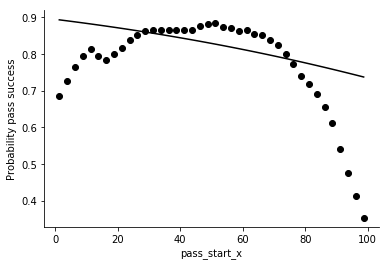

In [205]:
calculate_and_plot_linear_regression_curve(pass_data, ['pass_start_x'])

This doesn't look great, let's have a look at what happens if we include x<sup>2</sup> too

In [198]:
pass_data['pass_start_x_squared'] = pass_data['pass_start_x']**2
pass_data['pass_start_y_squared'] = pass_data['pass_start_y']**2

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.3285e+05
Date:                                 Sat, 12 Sep 2020   Deviance:                   1.4657e+06
Time:                                         21:11:31   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

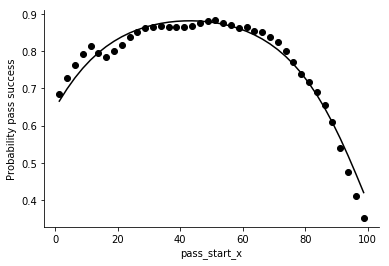

In [206]:
calculate_and_plot_linear_regression_curve(pass_data, ['pass_start_x', 'pass_start_x_squared'])

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665504
Model Family:                                 Binomial   Df Model:                            1
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.6056e+05
Date:                                 Sat, 12 Sep 2020   Deviance:                   1.5211e+06
Time:                                         21:12:27   Pearson chi2:                 1.67e+06
No. Iterations:                                      4                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

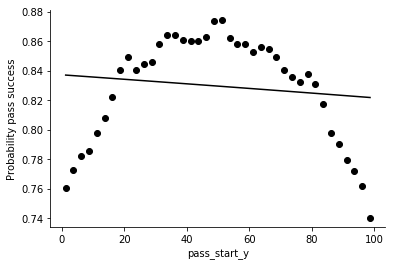

In [207]:
calculate_and_plot_linear_regression_curve(pass_data, ['pass_start_y'])

As was the case for x, this is pretty terrible. But we always thought a quadratic may make more sense. Let's look into that.

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5422e+05
Date:                                 Sat, 12 Sep 2020   Deviance:                   1.5084e+06
Time:                                         21:13:24   Pearson chi2:                 1.67e+06
No. Iterations:                                      5                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

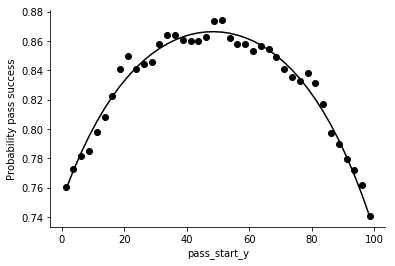

In [208]:
calculate_and_plot_linear_regression_curve(pass_data, ['pass_start_y', 'pass_start_y_squared'])

In [160]:
test_model = smf.glm(formula="success ~ pass_start_x + pass_start_y" , data=pass_data, 
                     family=sm.families.Binomial()).fit()
print(test_model.summary()) 

                          Generalized Linear Model Regression Results                          
Dep. Variable:     ['success[False]', 'success[True]']   No. Observations:              1665506
Model:                                             GLM   Df Residuals:                  1665503
Model Family:                                 Binomial   Df Model:                            2
Link Function:                                   logit   Scale:                             1.0
Method:                                           IRLS   Log-Likelihood:            -7.5374e+05
Date:                                 Sat, 12 Sep 2020   Deviance:                   1.5075e+06
Time:                                         17:49:42   Pearson chi2:                 1.68e+06
No. Iterations:                                      5                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------